# Top-$N$ Random Forest Model

In this notebook we construct a random forest classifier to compute probabilities of ultimate purchase for all previously purchased user-product pairs. Next, we select top probability scores to provide recommendations using top-$N$ variants for different use cases.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

pd.options.display.latex.repr=True

### Load Data

In [2]:
store = pd.HDFStore('../input/instacart-feature-engineering/io.h5', 'r')
store.open()
store.keys()

Opening ../input/instacart-feature-engineering/io.h5 in read-only mode


['/X/kaggle', '/X/test', '/X/train', '/y/kaggle', '/y/test', '/y/train']

In [3]:
dsets = ['train', 'test', 'kaggle']

X = dict.fromkeys(dsets)
y = dict.fromkeys(dsets)

for ds in dsets:
    X[ds] = store['/X/' + str(ds)]
    y[ds] = store['/y/' + str(ds)]

In [4]:
store.close()
store.is_open

False

## Random Forest Classifier
Initialize and fit the random forest classifier

In [5]:
# Import necessary modules
import matplotlib.pyplot as plt
import pandas as pd

import datetime
from scipy.stats import randint

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [6]:
# Initialize and fit classifier
rfc = RandomForestClassifier(n_estimators=600,
                             max_features='sqrt',
                             min_impurity_decrease=3e-7,
                             min_samples_leaf=24,
                             n_jobs=-1,
                             random_state=20190603,
                             oob_score=True,
                             warm_start=True)

print(datetime.datetime.now())

rfc.fit(X['train'], y['train'].values.ravel())

print(datetime.datetime.now())

oob_error = 1 - rfc.oob_score_

2019-06-11 19:32:57.834007
2019-06-11 23:11:43.675828


Let's take a look at the node sizes of the trees.

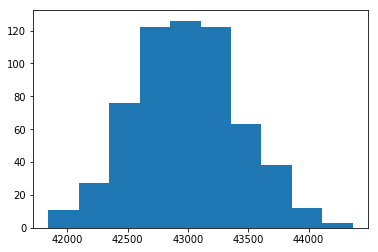

In [7]:
# tree_.node_count estimators

node_counts = [rfc.estimators_[i].tree_.node_count for i in range(len(rfc.estimators_))]

plt.hist(node_counts)
plt.show()

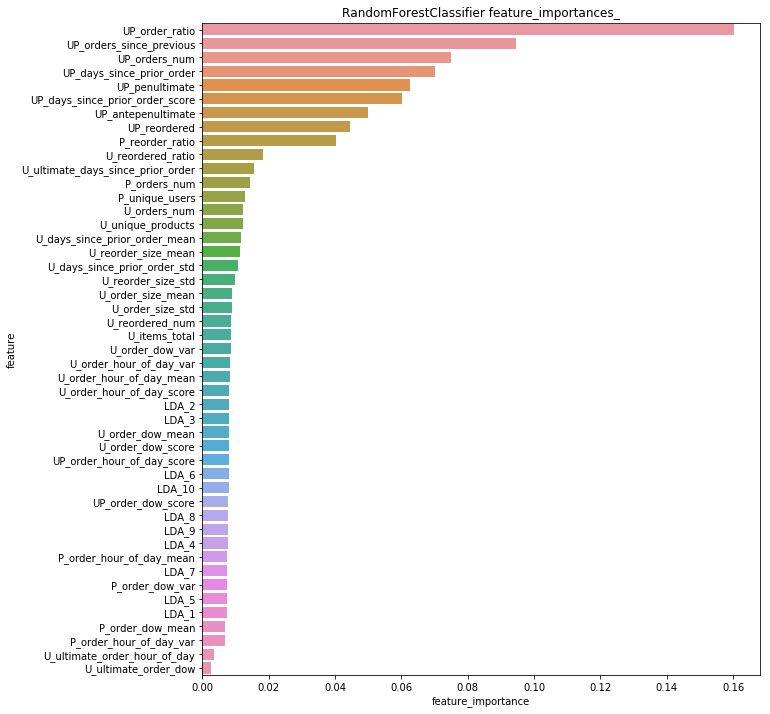

In [8]:
plt.figure(figsize=(10,12))
sns.barplot(data=(pd.DataFrame(data=rfc.feature_importances_,
           index=X['train'].columns)
                  .reset_index()
                  .sort_values(by=0,ascending=False)
                  .rename(columns = {'index': 'feature',
                                     0: 'feature_importance'}
                         )
                 ),
            x='feature_importance',
            y='feature'
           )
plt.title('RandomForestClassifier feature_importances_')
plt.show()

The `feature_importances_` attribute shows that one of the most fruitful avenues to pursue to improve classifier performance is to focus on manually creating additional user-product features which capture more complex user-product interactions.

## Random Forest Classifier Metrics

The data has an imbalance on the order of $\text{Skew} = 10$. Since any given basket typically has far fewer items than the total previous products a user has purchased, there are many more actual negatives than actual positives. The ease of finding negatives inflates the AUC score; the precision-recall curve shows the classifier has predictive power only for larger classification probability threshold values. [Reference](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

In [9]:
# Create a dictionary of metrics to compute multiple scores

from imblearn.metrics import geometric_mean_score

metrics_dict = {}

metrics_dict['auc_roc'] = {'fcn' : metrics.roc_auc_score,
                        'name': 'AUC-ROC',
                        'thr' : False}

metrics_dict['auc_pr'] = {'fcn' : metrics.average_precision_score,
                        'name': 'AUC-PR',
                        'thr' : False}

metrics_dict['log_loss'] = {'fcn' : metrics.log_loss,
                        'name': 'Log Loss',
                        'thr' : False}

metrics_dict['prec'] = {'fcn' : metrics.precision_score,
                        'name': 'Precision',
                        'thr' : True}

metrics_dict['rec'] = {'fcn' : metrics.recall_score,
                        'name': 'Recall',
                        'thr' : True}

metrics_dict['f1'] = {'fcn' : metrics.f1_score,
                        'name': 'F1 Score',
                        'thr' : True}

metrics_dict['bal_acc'] = {'fcn' : metrics.balanced_accuracy_score,
                        'name': 'Balanced Accuracy',
                        'thr' : True}

metrics_dict['g_mean'] = {'fcn' : geometric_mean_score,
                        'name': 'Geometric Mean',
                        'thr' : True}

metrics_dict['kappa'] = {'fcn' : metrics.cohen_kappa_score,
                        'name': 'Cohen\'s Kappa',
                        'thr' : True}

Using TensorFlow backend.


In [10]:
# oob scores
y_score = rfc.oob_decision_function_

# predictions
y_predict_binary = dict.fromkeys(dsets)
y_predict_proba = dict.fromkeys(dsets)
y_predict_proba_df = dict.fromkeys(dsets)

for ds in dsets:
    # binary predictions
    y_predict_binary[ds] = rfc.predict(X[ds])

    # probability of True
    y_predict_proba[ds] = rfc.predict_proba(X[ds])[:, 1]

    # True probabilities as Series
    y_predict_proba_df[ds] = pd.Series(data=y_predict_proba[ds],
                                         index=X[ds].index)

### ROC Curve

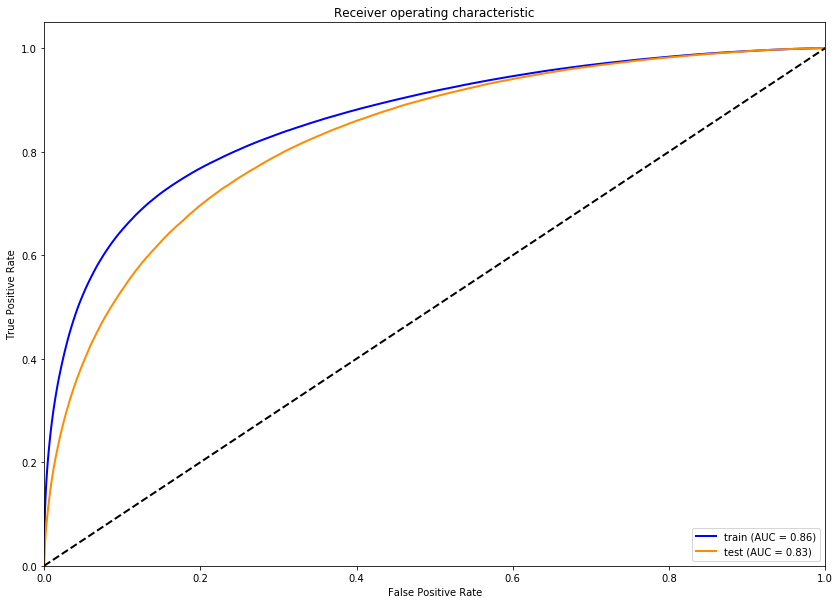

In [11]:
fpr = dict.fromkeys(dsets)
tpr = dict.fromkeys(dsets)
roc_auc = dict.fromkeys(dsets)

for ds in dsets[:2]:
    fpr[ds], tpr[ds], _ = metrics.roc_curve(y[ds], y_predict_proba[ds])
    roc_auc[ds] = metrics.roc_auc_score(y[ds], y_predict_proba[ds])

plt.figure(figsize=(14,10))
lw = 2
plt.plot(fpr['train'], tpr['train'], color='blue',
         lw=lw, label='train (AUC = %0.2f)' % roc_auc['train'])
plt.plot(fpr['test'], tpr['test'], color='darkorange',
         lw=lw, label='test (AUC = %0.2f)' % roc_auc['test'])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Precision-Recall Curve

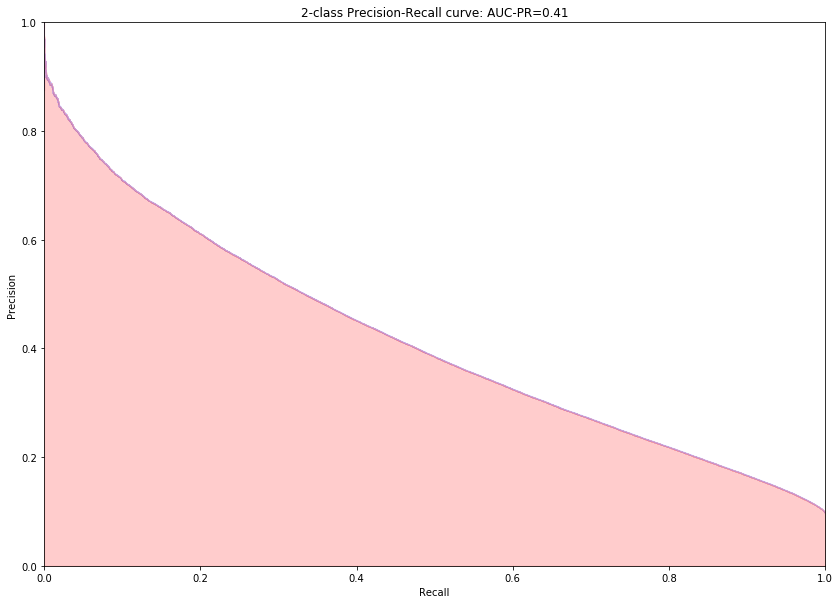

In [12]:
# adapted from sklearn docs
from sklearn.utils.fixes import signature

precision, recall, _ = metrics.precision_recall_curve(y['test'], y_predict_proba['test'])

average_precision = metrics.average_precision_score(y['test'], y_predict_proba['test'])

# # Iso-F1
# for i in np.linspace(0.2, 0.9, 7, endpoint=False):
#     plt.plot(xs, xs * i / (2 * xs - i), color='navy')

plt.figure(figsize=(14,10))

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='r', **step_kwargs)


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC-PR={0:0.2f}'.format(
          average_precision))
plt.show()

## Top-$N_\text{threshold}$ Variants

If we choose the $N_\text{threshold}$ user-product pairs $(u,p)$ with the greatest $P((u,p))$, then this top-$N$ variant is a reparamaterization of the classification threshold, $p_0$, via
$$N_\text{threshold} =  \left\{ (u,p) \ | \ P((u,p)) > p_0 \right\}.$$

An advantage of this variant is that it recommends the items users are, in aggregate, most likely to purchase. Therefore, we can, overall, make the 'best' recommendations. A disadvantage is that there is a lot variation in the number of recommended products.

A few potentially principled choices for $N$ follow:

### $N_{0.5}$

A direct interpretation of `y_predict_proba` in terms of probabilities would make a threshold of $p_0 = 0.5$ the most principled choice. On the other hand, choices made in the model definition and implementation could make this interpretation dubious. Nonetheless, we can define $$N_{0.5} = \left\{ (u,p) \ | \ P((u,p)) > 0.5 \right\}$$ to take a look at scores.

### $N_\text{skew}$

It may instead be most principled to choose $N$ such that the skew of predictions equals the `train` skew (negative classes divided by positive classes). Let $y_\oplus$ be the count of positive classes (`train`) and $y_\ominus$ be the count of negative classes (`train`). We compute `skew_train` as $\mathrm{skew} = y_\ominus / y_\oplus$. For $s \in \mathrm{DSets}$, let $n_s = |I_s|$, the length of the multiindex of user-product pairs. Define
$$N_{\text{skew}_s} := n_s * P(y_\oplus) = \frac{n_s}{1+\mathrm{skew}},$$
where $$P(y_\oplus) = \frac{y_\oplus}{y_\oplus + y_\ominus}$$
is the ratio of positive classes in `train` to the length of `train`.

In [13]:
skew_train = ((y['train'].count() - y['train'].sum())/y['train'].sum())

print('The skew of the training data set is skew_train = %.2f.' % skew_train)

The skew of the training data set is skew_train = 9.20.


### $N_\text{basket}$

A couple other values we may consider to be principled are
$$ N_\text{basket} = \sum_{u \in U} \overline{ b(u) }$$
$$ N_\text{basket reorder} = \sum_{u \in U} \overline{ r(u) }$$
where $\overline{b(u)}$ is the mean basket size for user $u$ and $\overline{ r(u)}$ is the mean reordered items per basket for user $u$.

### Prediction Vectors

In [14]:
variant_group = 'N_threshold'

In [15]:
# Compute N

N_05 = dict.fromkeys(dsets)
N_skew = dict.fromkeys(dsets)
N_basket = dict.fromkeys(dsets)
N_basket_reorder = dict.fromkeys(dsets)

for ds in dsets:
    N_05[ds] = y_predict_binary[ds].sum()
    
    N_skew[ds] = int(len(y_predict_proba_df[ds]) / (1 + skew_train))    
    
    N_basket[ds] = int(X[ds].U_order_size_mean
                        .groupby('user_id')
                        .max()
                        .astype('float64')
                        .sum())
    
    N_basket_reorder[ds] = int(X[ds].U_reorder_size_mean
                        .groupby('user_id')
                        .max()
                        .astype('float64')
                        .sum())

In [16]:
# Compute binary prediction vectors

y_topN_05 = dict.fromkeys(dsets)
y_topN_skew = dict.fromkeys(dsets)
y_topN_basket = dict.fromkeys(dsets)
y_topN_basket_reorder = dict.fromkeys(dsets)

for ds in dsets:
    y_topN_05[ds] = pd.Series(data=y_predict_binary[ds],
                              index=X[ds].index)
    
    y_topN_skew[ds] = pd.Series(data=True,
                         index=y_predict_proba_df[ds]
                         .nlargest(N_skew[ds])
                         .index).reindex_like(X[ds]).fillna(False)  
        
    y_topN_basket[ds] = pd.Series(data=True,
                         index=y_predict_proba_df[ds]
                         .nlargest(N_basket[ds])
                         .index).reindex_like(X[ds]).fillna(False)

    y_topN_basket_reorder[ds] = pd.Series(data=True,
                         index=y_predict_proba_df[ds]
                         .nlargest(N_basket_reorder[ds])
                         .index).reindex_like(X[ds]).fillna(False)

In [17]:
# proba thresholds (test)

p_05 = dict.fromkeys(dsets)
p_skew = dict.fromkeys(dsets)
p_basket = dict.fromkeys(dsets)
p_basket_reorder = dict.fromkeys(dsets)

for ds in dsets:
    p_05[ds] = 0.5
    p_skew[ds] = float(y_predict_proba_df[ds]
                       .nlargest(N_skew[ds])
                       .tail(1))
    p_basket[ds] = float(y_predict_proba_df[ds]
                         .nlargest(N_basket[ds])
                         .tail(1))
    p_basket_reorder[ds] = float(y_predict_proba_df[ds]
                                 .nlargest(N_basket_reorder[ds])
                                 .tail(1))    

In [18]:
# Create a dictionary of the predictions of various variants

from collections import defaultdict

variants_dict = defaultdict(dict)

variants_dict[variant_group]['N_05'] = {
    'N' : N_05,
    'y' : y_topN_05,
    'p' : p_05
}

variants_dict[variant_group]['N_skew'] = {
    'N' : N_skew,
    'y' : y_topN_skew,
    'p' : p_skew
}

variants_dict[variant_group]['N_basket'] = {
    'N' : N_basket,
    'y' : y_topN_basket,
    'p' : p_basket
}

variants_dict[variant_group]['N_basket_reorder'] = {
    'N' : N_basket_reorder,
    'y' : y_topN_basket_reorder,
    'p' : p_basket_reorder
}

#### Inspect $N$ and $p$ values

In [19]:
pd.concat(
    {
        ds: pd.DataFrame({
            variant: {
                col: variants_dict[variant_group][variant][col][ds]
                for col in variants_dict[variant_group][variant].keys()
            }
            for variant in variants_dict[variant_group].keys()
        }).transpose()[['N', 'p']].assign(
            N_frac=lambda x: x['N'] / len(y[ds])).sort_index(axis=1)
        for ds in dsets[:2]
    },
    axis=1)

test               ...         train          
                       N     N_frac    ...        N_frac         p
N_05               43409  0.0253281    ...     0.0276965       0.5
N_skew            168015  0.0980325    ...     0.0980329  0.256642
N_basket          261198   0.152402    ...      0.154374  0.177169
N_basket_reorder  116952  0.0682385    ...     0.0687853  0.325667

[4 rows x 6 columns]

#### Inspect Basket Sizes ('train'):

In [20]:
pd.concat([
    y_topN_05['train'].groupby('user_id').sum()
    .astype('int').rename('top_N_05_pred'),
    y_topN_skew['train'].groupby('user_id').sum()
    .astype('int').rename('top_N_skew_pred'),
    y_topN_basket['train'].groupby('user_id').sum()
    .astype('int').rename('top_N_basket_pred'),
    y_topN_basket_reorder['train'].groupby('user_id').sum()
    .astype('int').rename('top_N_basket_reorder_pred'),
    X['train'].U_order_size_mean.groupby('user_id').max(),
    X['train'].U_reorder_size_mean.groupby('user_id').max(),
],
axis=1).head(15)

,top_N_05_pred,top_N_skew_pred,top_N_basket_pred,top_N_basket_reorder_pred,U_order_size_mean,U_reorder_size_mean
user_id,,,,,,
1,5,10,10,8,5.898438,4.101562
2,1,9,14,3,13.929688,6.644531
7,3,12,17,9,10.296875,6.898438
8,0,8,15,4,16.328125,4.332031
9,2,32,37,25,25.328125,6.000000
10,0,10,23,5,28.593750,9.796875
13,3,5,8,4,6.750000,4.332031
14,2,6,7,6,16.156250,5.230469
17,2,4,6,4,7.351562,5.273438


There is a good deal of variation in basket size prediction and sometimes a considerable mismatch between predictions and mean basket sizes. This may be a reason for the threshold variant to be of less practical relevance from a product standpoint.

### Scores

In [21]:
# Make a dataframe with one row of threshold metrics to score y_pred from
# a dictionary of metrics of the form metrics_dict

def scores_dataframe(y_true_dict, y_pred_dict, metrics_dict, col_name=0):
    
    cols = []
    scores = []

    for ds in dsets[:2]:
        for key, metric in metrics_dict.items():
            if metric['thr'] == True:
                cols.append((ds, metric['name']))
                scores.append(metric['fcn'](y_true_dict[ds].values.ravel(),
                                            y_pred_dict[ds].values.ravel()))

    return pd.DataFrame(data=[scores],
                        columns=pd.MultiIndex.from_tuples(cols, names=['dset', 'metric']),
                        index=[col_name])

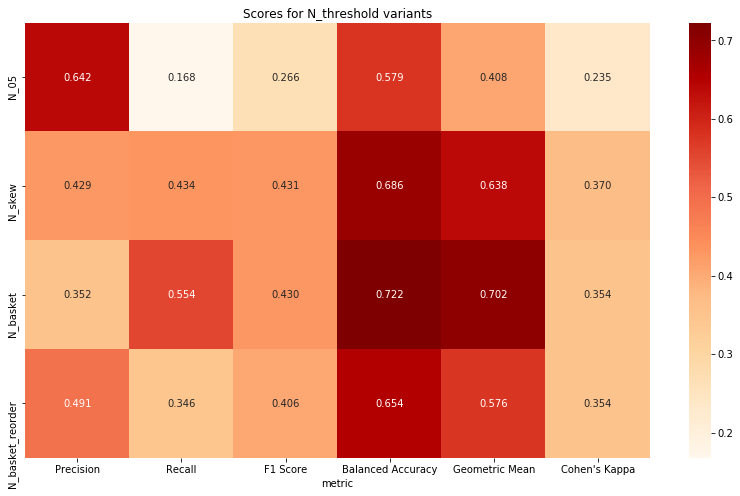

In [22]:
plt.figure(figsize=(14,8))
plt.title('Scores for ' + variant_group + ' variants')
sns.heatmap(
pd.concat(
    [scores_dataframe(y, val['y'], metrics_dict, key)['test']
    for key, val in variants_dict[variant_group].items()]),
    annot=True,
    fmt='.3f',
    cmap="OrRd"
)
plt.show()

Note the heatmap colors are only comparable *within columns*.

Since $N_\text{basket}$ is greater than $N_\text{basket reorder}$, the latter choice has greater precision, while $N_\text{skew}$ balances precision and recall. We may not necessarily care about high precision scores. Avoiding false negatives is not an issue if we want to be more liberal in recommendations.

### Confusion Matrices

In [23]:
# Confusion matrix in a standard format

def make_confusion_df(y_test, y_pred):
    cm = metrics.confusion_matrix(
        y_test, y_pred
    )

    return (pd.DataFrame(data=cm)
            .iloc[::-1,::-1]
            .rename_axis('Predicted Label')
            .rename_axis('True Label', axis=1))

In [24]:
# Make a normed confusion matrix (recall version)
# for variant in the keys of variant_group
# and 'test' set and y_pred_dict of form variants_dict

def make_norm_confusion_df(y_test, y_pred_dict, variant_group, variant):
    cm = metrics.confusion_matrix(
        y_test,
        y_pred_dict[variant_group][variant]['y']['test']
    )
    
    long_form_matrix_df = (pd.DataFrame(
        data=(cm / (cm.sum(axis=1)[:, np.newaxis])))
            .iloc[::-1,::-1]
            .rename_axis('Predicted Label')
            .rename_axis('True Label', axis=1)
    .reset_index()
    .melt(id_vars=['Predicted Label'])
    .assign(variant=variant))
    
    cols = long_form_matrix_df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    long_form_matrix_df = long_form_matrix_df[cols]
    
    return long_form_matrix_df

In [25]:
# Concatenate long-form confusion matrices in single df

def combine_norm_confusion_df(y_test, y_pred_dict, variant_group):
    return pd.concat(
    [make_norm_confusion_df(y_test, y_pred_dict, variant_group, variant)
    for variant in variants_dict[variant_group].keys()]
    )

[SO on normalized confusion](https://stackoverflow.com/a/20934655)

In [26]:
# Plot function for FacetGrid use:
# From long format df (kw-packed), pivot and plot heatmap

def draw_heatmap(index, columns, values, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=index,
                   columns=columns,
                   values=values).iloc[::-1,::-1]
    sns.heatmap(d, **kwargs)

In [27]:
# Create long ('tidy') DataFrame of confusion matrices

confusion_matrices_long = combine_norm_confusion_df(y['test'], variants_dict, variant_group)

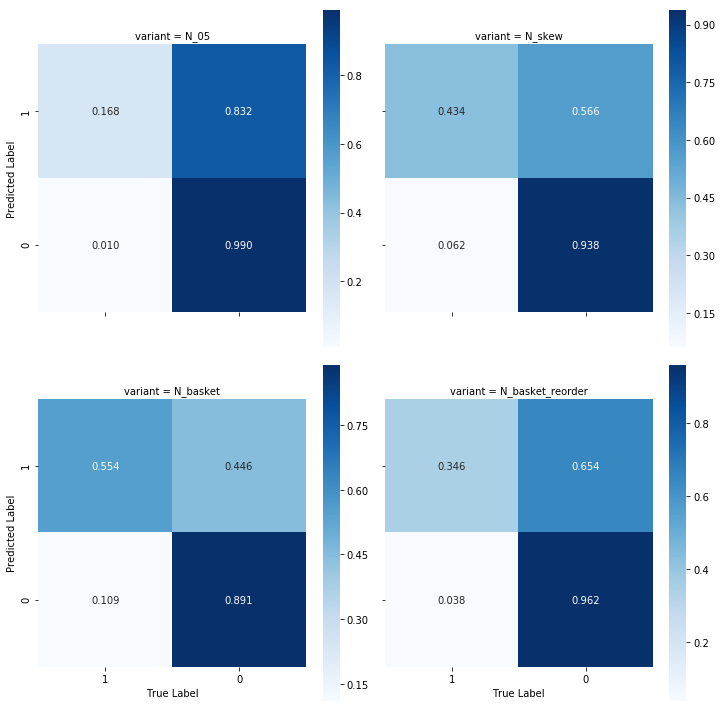

In [28]:
# Plot normalized confusion heatmaps on FacetGrid

fg = sns.FacetGrid(confusion_matrices_long,
                   col='variant',
                   col_wrap=2,
                   height=5)

fg.map_dataframe(draw_heatmap,
                 index='Predicted Label', 
                 columns='True Label',
                 values='value',
                 square=True,
                 annot=True,
                 fmt='0.3f',
                 cmap='Blues')

fg.set_axis_labels('True Label', 'Predicted Label')

plt.show()

## Top-$N(u)$ Variant
If we want to avoid the high variation of basket sizes in the top-$N_\text{total}$ variant, we can define ultimate basket sizes by user. Let
$$N(u) = \left\lceil \overline{b(u)} \right\rceil$$
$$N_\text{reorder}(u) = \left\lceil \overline{r(u)} \right\rceil$$
for all $u \in U$, that is, the ceiling of the mean (re)orders per basket for user $u$. Using the ceiling rather than round or floor offers the advantage of recommending at least one item to users in a straight-forward way. The mean reorders per basket is biased even as a predictor of ultimate *re*orders since user's initial orders have zero reorders. On the other hand, since we are predicting fewer positives, the precision of $N_\text{reorder}(u)$ is better.

These kinds of variants, or those which offer control of ultimate basket size while offering more flexibility in that control, may be useful for product applications like auto-populating user carts with items we most expect users to reorder. For such an application we would prefer models with higher precision.

In [29]:
variant_group = 'N_u'

In [30]:
# Compute N_u

N_u = dict.fromkeys(dsets)
N_u_reorder = dict.fromkeys(dsets)

for ds in dsets:
    N_u[ds] = (X[ds].U_order_size_mean
                        .groupby('user_id')
                        .max()
                        .apply(np.ceil)
                        .astype('uint8'))

    N_u_reorder[ds] = (X[ds].U_reorder_size_mean
                        .groupby('user_id')
                        .max()
                        .apply(np.ceil)
                        .astype('uint8'))

This [top-$N(u)$ `groupby()` reference](https://stackoverflow.com/questions/37482733/selecting-top-n-elements-from-each-group-in-pandas-groupby) was helpful.

In [31]:
# Compute binary prediction vectors

y_top_N_u = dict.fromkeys(dsets)
y_top_N_u_reorder = dict.fromkeys(dsets)

for ds in dsets:
    y_top_N_u[ds] = (pd.Series(data=True,
                          index=y_predict_proba_df[ds].groupby('user_id')
                          .apply(lambda gp: gp.nlargest(N_u[ds].loc[gp.name]))
                          .reset_index(level=1, drop=True).index)
                 .reindex_like(X[ds])
                 .fillna(False))
    y_top_N_u_reorder[ds] = (pd.Series(data=True,
                      index=y_predict_proba_df[ds].groupby('user_id')
                      .apply(lambda gp: gp.nlargest(N_u_reorder[ds].loc[gp.name]))
                      .reset_index(level=1, drop=True).index)
             .reindex_like(X[ds])
             .fillna(False))

In [32]:
# Note this is not a threshold variant so there are no 'p' keys

variants_dict[variant_group]['N_u'] = {
    'N' : N_u,
    'y' : y_top_N_u
}

variants_dict[variant_group]['N_u_reorder'] = {
    'N' : N_u_reorder,
    'y' : y_top_N_u_reorder
}

#### Inspect Basket Sizes

Note this variant group is defined by *setting* basket sizes to user mean basket sizes:

In [33]:
pd.concat([y_top_N_u['train'].groupby('user_id').sum().rename('top_N_u_pred'),
           y_top_N_u_reorder['train'].groupby('user_id').sum().rename('top_N_reorder_u_pred'),
           X['train'].U_order_size_mean.groupby('user_id').max(),
           X['train'].U_reorder_size_mean.groupby('user_id').max()
          ],
          axis=1).head(15)

,top_N_u_pred,top_N_reorder_u_pred,U_order_size_mean,U_reorder_size_mean
user_id,,,,
1,6.0,5.0,5.898438,4.101562
2,14.0,7.0,13.929688,6.644531
7,11.0,7.0,10.296875,6.898438
8,17.0,5.0,16.328125,4.332031
9,26.0,6.0,25.328125,6.000000
10,29.0,10.0,28.593750,9.796875
13,7.0,5.0,6.750000,4.332031
14,17.0,6.0,16.156250,5.230469
17,8.0,6.0,7.351562,5.273438


Of course now there is no difference between mean basket sizes and predictions. Although we have not (yet) created a variant which offers a compromise between the high variation in differences of mean basket size and prediction of `N_threshold` and the (near) zero variation in differences of mean basket size and prediction of `N_u`, there are many such variants which would be straight-forward to construct.

### Scores

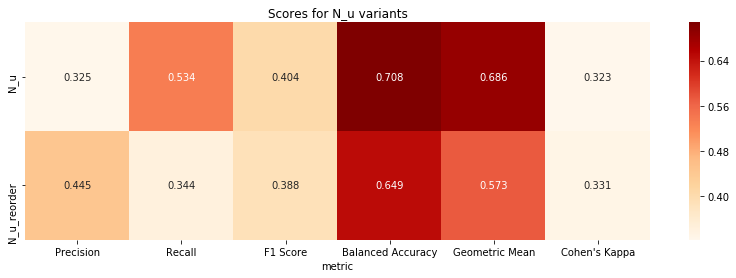

In [34]:
plt.figure(figsize=(14,4))
plt.title('Scores for ' + variant_group + ' variants')
sns.heatmap(
pd.concat(
    [scores_dataframe(y, val['y'], metrics_dict, key)['test']
    for key, val in variants_dict[variant_group].items()]),
    annot=True,
    fmt='.3f',
    cmap="OrRd"
)
plt.show()

### Confusion Matrices

In [35]:
# Create long ('tidy') DataFrame of confusion matrices

confusion_matrices_long = combine_norm_confusion_df(y['test'], variants_dict, variant_group)

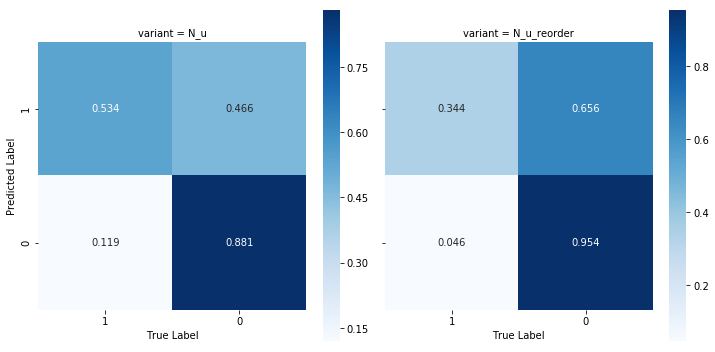

In [36]:
# Plot normalized confusion heatmaps on FacetGrid

fg = sns.FacetGrid(confusion_matrices_long,
                   col='variant',
                   col_wrap=2,
                   height=5)

fg.map_dataframe(draw_heatmap,
                 index='Predicted Label', 
                 columns='True Label',
                 values='value',
                 square=True,
                 annot=True,
                 fmt='0.3f',
                 cmap='Blues')

fg.set_axis_labels('True Label', 'Predicted Label')

plt.show()

## Top-$N$

While the top-$N_u$ model gives better predictions, a top-$N$ model with a fixed $N$ for all users may be useful, for example, in displaying previously purchased product recommendations on a web page of fixed size. Below are scores for $N \in \left\{4, 8, 12, 16, 20, 24\right\}$. An application like this one would prefer higher recall models.

In [37]:
variant_group = 'top_N'

In [38]:
# Define Ns

Ns = list(range(4,25,4))

y_top = []
for N in Ns:
    y_top.append(dict.fromkeys(dsets))

In [39]:
# Compute top-N predictions and add to variants_dict

for N in Ns:
    for ds in dsets:
        y_top[Ns.index(N)][ds] = (pd.Series(data=True,
                          index=y_predict_proba_df[ds].groupby('user_id')
                          .nlargest(N)
                          .reset_index(level=1, drop=True).index)
                 .reindex_like(X[ds])
                 .fillna(False))
        
        variants_dict[variant_group][N] = {
            'N' : N,
            'y' : y_top[Ns.index(N)]
        }

### Scores

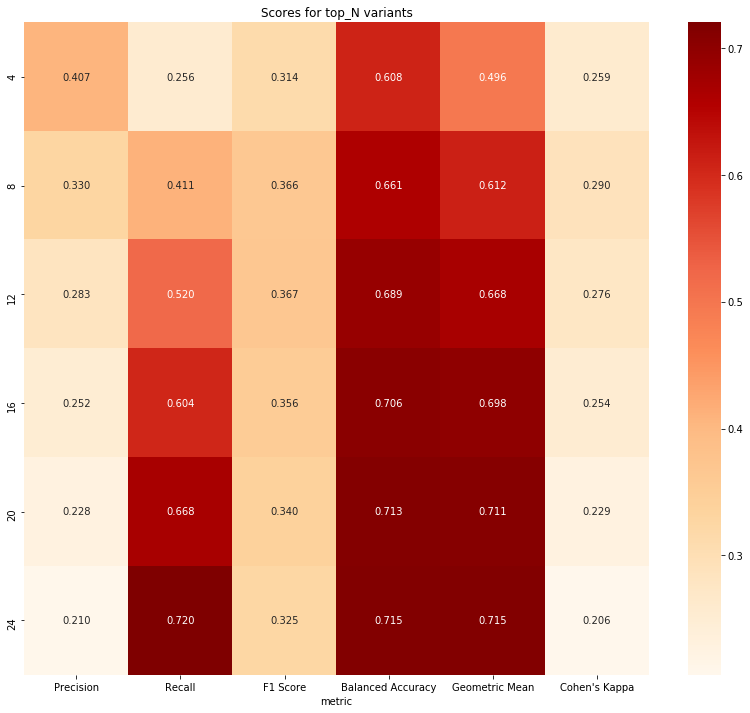

In [40]:
plt.figure(figsize=(14,12))
plt.title('Scores for ' + variant_group + ' variants')
sns.heatmap(
pd.concat(
    [scores_dataframe(y, val['y'], metrics_dict, key)['test']
    for key, val in variants_dict[variant_group].items()]),
    annot=True,
    fmt='.3f',
    cmap="OrRd"
)
plt.show()

### Confusion Matrices

In [41]:
# Create long ('tidy') DataFrame of confusion matrices

confusion_matrices_long = combine_norm_confusion_df(y['test'], variants_dict, variant_group)

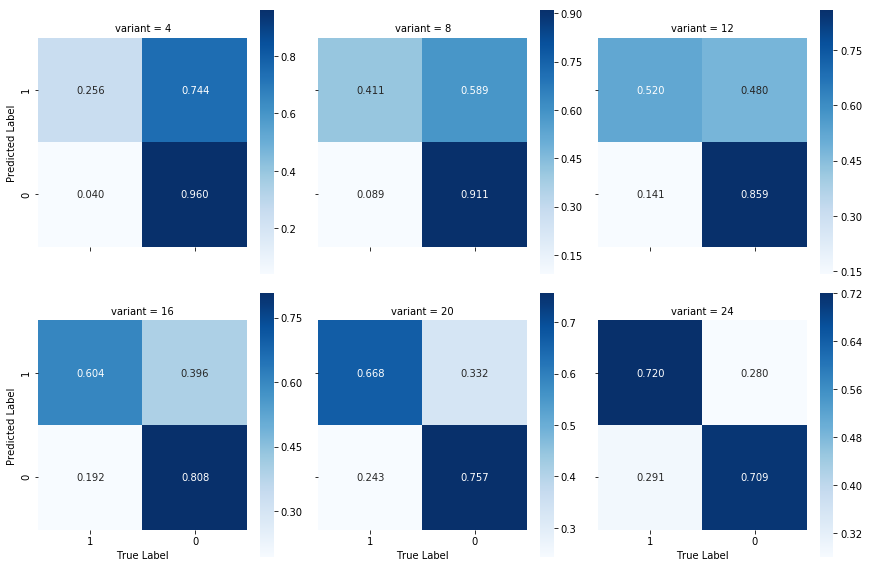

In [42]:
# Plot normalized confusion heatmaps on FacetGrid

fg = sns.FacetGrid(confusion_matrices_long,
                   col='variant',
                   col_wrap=3,
                   height=4)

fg.map_dataframe(draw_heatmap,
                 index='Predicted Label', 
                 columns='True Label',
                 values='value',
                 square=True,
                 annot=True,
                 fmt='0.3f',
                 cmap='Blues')

fg.set_axis_labels('True Label', 'Predicted Label')

plt.show()

## Kaggle Output (sanity check)

Additional threshold choices for Kaggle submission:

In [43]:
variant_group = 'p_kaggle'

In [44]:
# Compute kaggle threshold predictions and add to variants_dict

p_0s = list(np.round(np.linspace(0.192, 0.198, num=4), 3))

y_kaggle = []

for p_0 in p_0s:
    for ds in dsets:
        y_kaggle.append(dict.fromkeys(dsets))
        y_kaggle[p_0s.index(p_0)][ds] = pd.Series((y_predict_proba_df[ds] >= p_0))
        
        variants_dict[variant_group][p_0] = {
            'y' : y_kaggle[p_0s.index(p_0)]
        }

### Scores

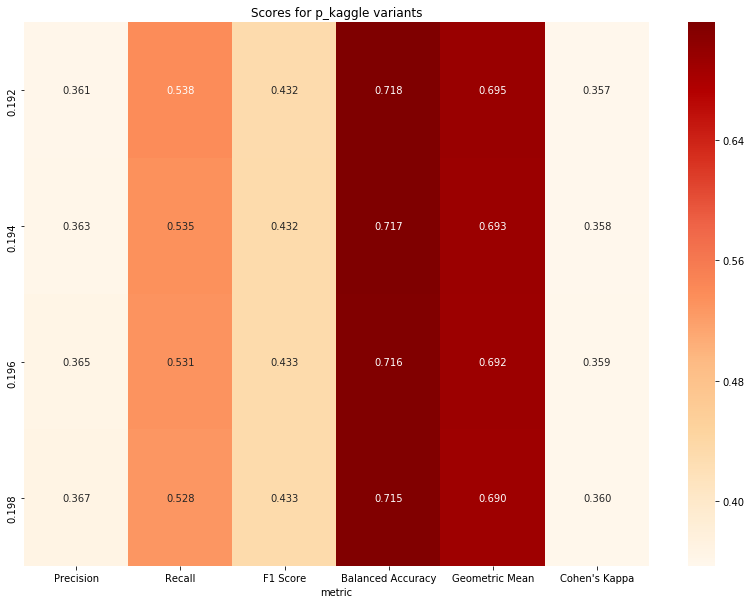

In [45]:
plt.figure(figsize=(14,10))
plt.title('Scores for ' + variant_group + ' variants')
sns.heatmap(
pd.concat(
    [scores_dataframe(y, val['y'], metrics_dict, key)['test']
    for key, val in variants_dict[variant_group].items()])
    .sort_index(),
    annot=True,
    fmt='.3f',
    cmap="OrRd"
)
plt.show()

### Confusion Matrices

In [46]:
# Create long ('tidy') DataFrame of confusion matrices

confusion_matrices_long = combine_norm_confusion_df(y['test'], variants_dict, variant_group)

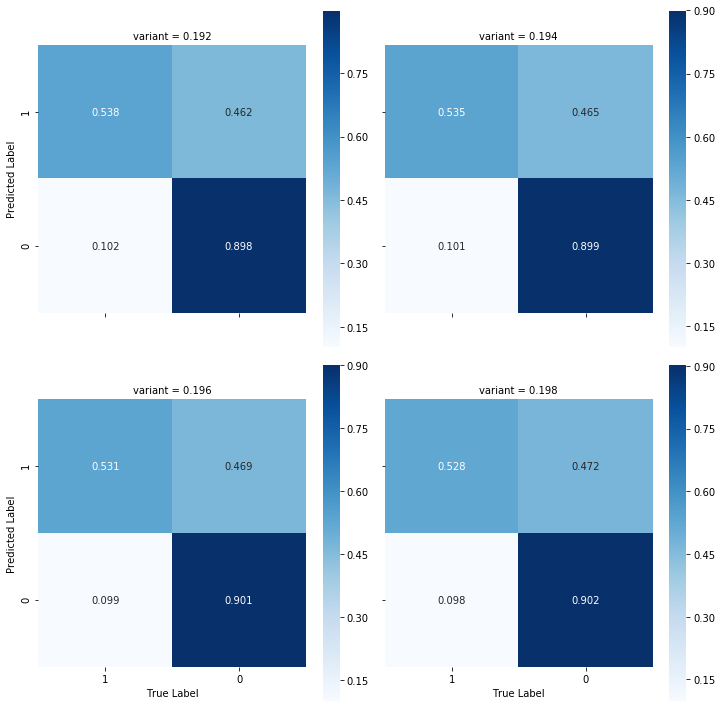

In [47]:
# Plot normalized confusion heatmaps on FacetGrid

fg = sns.FacetGrid(confusion_matrices_long,
                   col='variant',
                   col_wrap=2,
                   height=5)

fg.map_dataframe(draw_heatmap,
                 index='Predicted Label', 
                 columns='True Label',
                 values='value',
                 square=True,
                 annot=True,
                 fmt='0.3f',
                 cmap='Blues')

fg.set_axis_labels('True Label', 'Predicted Label')

plt.show()

In [48]:
# Output all predictions to .csv

for var_gp_name, var_gp in variants_dict.items():
    for var_name, var in var_gp.items():
        for ds in dsets:
            pd.DataFrame(data=var['y'][ds],
                         index=X[ds].index
                        ).to_csv(str(var_gp_name) + '-' + str(var_name) + '-' + str(ds) + '.csv')